# 前言

优化问题是金融中基础、不可避免的问题，从均值方差的二次规划开始， 优化问题已经深入到金融领域的方方面面，从大类资产配置到组合优化、从理论模型下的效用最大化再到实战模型的参数优化，都用到优化技术。而很多优化问题较为复杂，非凸、不连续、不可导、高维、随机、约束过多等问题给数 值计算带来困扰，本文提出**次优理论**并且介绍差分进化算法，通过展示差分进 化算法的良好效果，希望给广大投资者的量化建模带来一丝启示。本文方法对组合优化、大类配置、FOF组合构建、智能投顾等领域都会有所帮助。

**当期优化的最优解不一定是下一期的最优，而样本内的次优在样本外可能战胜样本内的最优**。所以，从金融投资角度看，优化问题下的最优解不一定是我们想要的，因为我们的目标是获得较好的样本外收益表现。



In [1]:
# 初始库
import sys
sys.path.append('..')

from DE_algorithm import *
import numpy as np
import pandas as pd
import empyrical as ep
import scipy.stats as st

from tqdm import tqdm_notebook
from typing import (Tuple,List)
from dateutil.parser import parse

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from jqdata import *

# 设置字体 用来正常显示中文标签
#plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.family']='serif'

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

# 图表主题
plt.style.use('seaborn')

In [2]:
# 构造时间区间
def build_periods(start:str, end:str, freq:str,offsetN:int=None) -> Tuple[list, list]:
    '''构造区间'''

    # 半年度要特殊一点
    if freq == 'half':

        periods = [i.strftime(
            '%Y-%m-%d') for i in pd.date_range(start, end, freq='Q') if i.month in [6, 12]]

        end_range = periods[1:] + [end]
        start_range = periods

    else:

        periods = [i.strftime('%Y-%m-%d')
                   for i in pd.date_range(start, end, freq=freq)]

        start_range = periods[:-1]
        end_range = periods[1:]

    if offsetN:

        start_range = [tdaysoffset(i, offsetN) for i in start_range]
        end_range = [tdaysoffset(i, offsetN) for i in end_range]

        return (start_range, end_range)

    else:

        return (start_range, end_range)

# offset day
def tdaysoffset(end_date: str, count: int) -> datetime.date:
    '''
    end_date:为基准日期
    count:为正则后推，负为前推
    -----------
    return datetime.date
    '''

    trade_date = get_trade_days(end_date=end_date, count=1)[0]

    if count > 0:
        # 将end_date转为交易日

        trade_cal = get_all_trade_days().tolist()

        trade_idx = trade_cal.index(trade_date)

        return trade_cal[trade_idx + count]

    elif count < 0:

        return get_trade_days(end_date=trade_date, count=abs(count))[0]

    else:

        raise ValueError('别闹！')
        
# 风险指标
def Strategy_performance(return_df: pd.DataFrame, periods='monthly') -> pd.DataFrame:
    '''计算风险指标 默认为月度:月度调仓'''

    ser: pd.DataFrame = pd.DataFrame()
    ser['年化收益率'] = ep.annual_return(return_df, period=periods)
    ser['波动率'] = return_df.apply(lambda x: ep.annual_volatility(x,period=periods))
    ser['夏普'] = return_df.apply(ep.sharpe_ratio, period=periods)
    ser['最大回撤'] = return_df.apply(lambda x: ep.max_drawdown(x))
    
    if 'benchmark' in return_df.columns:

        select_col = [col for col in return_df.columns if col != 'benchmark']

        ser['IR'] = return_df[select_col].apply(
            lambda x: information_ratio(x, return_df['benchmark']))
        ser['Alpha'] = return_df[select_col].apply(
            lambda x: ep.alpha(x, return_df['benchmark'], period=periods))

    return ser.T

def information_ratio(returns, factor_returns):
    """
    Determines the Information ratio of a strategy.

    Parameters
    ----------
    returns : :py:class:`pandas.Series` or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        See full explanation in :func:`~empyrical.stats.cum_returns`.
    factor_returns: :class:`float` / :py:class:`pandas.Series`
        Benchmark return to compare returns against.

    Returns
    -------
    :class:`float`
        The information ratio.

    Note
    -----
    See https://en.wikipedia.org/wiki/information_ratio for more details.

    """
    if len(returns) < 2:
        return np.nan

    active_return = _adjust_returns(returns, factor_returns)
    tracking_error = np.std(active_return, ddof=1)
    if np.isnan(tracking_error):
        return 0.0
    if tracking_error == 0:
        return np.nan
    return np.mean(active_return) / tracking_error

def _adjust_returns(returns, adjustment_factor):
    """
    Returns a new :py:class:`pandas.Series` adjusted by adjustment_factor.
    Optimizes for the case of adjustment_factor being 0.

    Parameters
    ----------
    returns : :py:class:`pandas.Series`
    adjustment_factor : :py:class:`pandas.Series` / :class:`float`

    Returns
    -------
    :py:class:`pandas.Series`
    """
    if isinstance(adjustment_factor, (float, int)) and adjustment_factor == 0:
        return returns.copy()
    return returns - adjustment_factor



In [11]:
# 用于回测
def BackTesting(timeRange:List,weight:dict)->pd.DataFrame:
    '''
    timeRange:时间区间
    wieght:权重key-trade,values:pd.Series
    ----------------
        return 等权、优化权重、基准的收益率序列
    '''
    
    begin = min(timeRange[0])
    end = max(timeRange[1])
    idx = pd.to_datetime(get_trade_days(begin,end))
    # 缓存容器
    ret_df = pd.DataFrame(data=np.zeros((len(idx),2)),
                          index=idx,
                          columns=['opt_ret','equal_ret'])

    # 模拟回测
    ## 季度:beginDt日买入,至nextDt轮动
    for beginDt,nextDt in tqdm_notebook(zip(*timeRange),total=len(timeRange[0])):

        # 权重优化基于beginDt
        weight_ser = weight[beginDt] # 读取权重
        code = weight_ser.index.tolist()

        # 持仓从beginDt日至nextDt日
        price = get_price(code,beginDt,tdaysoffset(nextDt,1),fields='close',panel=False)
        close = pd.pivot_table(price,index='time',columns='code',values='close')
        pct_df = close.pct_change().shift(-1).iloc[:-1] # 收益滞后一期 防止未来数据

        ret_df.loc[pct_df.index,'opt_ret'] = pct_df @ weight_ser # 计算组合权重
        ret_df.loc[pct_df.index,'equal_ret'] = pct_df.mean(axis=1) # 等权
        
    benchmark = get_price('000300.XSHG',startDt,endDt,fields='close')
    benchmark = benchmark.pct_change().reindex(ret_df.index)
    ret_df['benchmark'] = benchmark
    return ret_df

## DE算法权重优化

差分进化算法参数是个技术活....

In [4]:
## 设置标的及时间范围
# 设置时间范围
startDt = '2014-01-01'
endDt = '2019-12-31'

# 设置调仓频率为季度
timeRange = build_periods(startDt,endDt,'Q')

# 设置标的
etfList = '510050.XSHG,510500.XSHG,510300.XSHG,159915.XSHE,510180.XSHG,159901.XSHE,159902.XSHE'.split(',')

# 测试数据获取
price = get_price(etfList,end_date = timeRange[0][0],count=126,fields='close',panel=False)

price = pd.pivot_table(price,index='time',columns='code',values='close')

pct_chg = price.pct_change().iloc[1:]

## 超参数

寻找在de进化算法下的最优初始参数

In [5]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from typing import (Callable)

'''使用sklearn接口用于超参'''
class DEPortfolioOpt(BaseEstimator):
    
    def __init__(self,func:Callable,size_pop:int,max_iter:int,F:float,proub_mut:float)->None:
        
        self.func = func           # 目标函数
        self.size_pop = size_pop   # 种群大小
        self.max_iter = max_iter   # 迭代次数
        self.F = F                 # 变异系数
        self.proub_mut = proub_mut # 变异概率
        
    def fit(self,returns:pd.DataFrame)->np.array:
        
        '''获取优化后的权重'''
        
        self.de = DE(func= lambda w:self.func(returns,w),
               n_dim = returns.shape[1],
               size_pop = self.size_pop,
               max_iter = self.max_iter,
               F=self.F,
               prob_mut = self.proub_mut,
               lb=[0],
               ub=[1],
               constraint_eq=[lambda x:1 - np.sum(x)])
        
        w,self.maxDrawdown = self.de.run()
        
        return pd.Series(w,index=returns.columns)
    
    def predict(self,returns)->float:
        '''获取权重后的收益率'''
        w = self.fit(returns)
        return returns @ w
    
    def score(self,returns)->float:
        '''评分根据优化后的回撤决定'''
        return -self.maxDrawdown
        

In [6]:
def maxDrawdown(pct_chg:pd.DataFrame,w:np.array)->float:
    '''目标函数'''
    return - ep.max_drawdown(pct_chg @ w)

In [52]:
# 网格超参
## 等待时间有点漫长大概1h+
param_grid = [{'F':np.arange(0.2,1.1,0.1),
              'proub_mut':np.arange(0.1,1.1,0.1)}]


de_portfolio = DEPortfolioOpt(maxDrawdown,150,250,0.5,1)

# cv默认为3flod
grid_search = GridSearchCV(de_portfolio,param_grid)

grid_search.fit(pct_chg)

GridSearchCV(cv=None, error_score='raise',
       estimator=DEPortfolioOpt(F=0.5, func=<function target_func at 0x7fea66a98e18>,
        max_iter=250, proub_mut=1, size_pop=150),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'F': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'proub_mut': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

最优参数为F:0.5,proub_mut:1

In [53]:
# 最优参数
grid_search.best_params_

{'F': 0.5000000000000001, 'proub_mut': 1.0}

In [54]:
equal = -ep.max_drawdown(pct_chg.mean(axis=1))
print('等权回撤:%.4f,优化回撤:%.4f'%(equal,- grid_search.best_estimator_.score(pct_chg)))

等权回撤:0.1179,优化回撤:0.0822


可以看到在迭代到200次时，曲线基本上没有什么变化了,所有将max_iter设置在200就差不多了

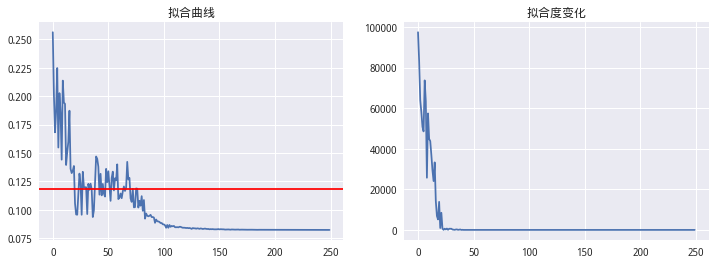

In [55]:
# 回撤情况    
maxdrawdownList = [-ep.max_drawdown(pct_chg @ w) for w in grid_search.best_estimator_.de.generation_best_X]

plt.rcParams['font.family']='serif'
fig,axes = plt.subplots(1,2,figsize=(6 * 2,4))

axes[0].set_title('拟合曲线')
axes[0].plot(maxdrawdownList,label='拟合的回撤')
axes[0].axhline(equal,color='r',label='等权回撤')

axes[1].set_title('拟合度变化')
axes[1].plot(grid_search.best_estimator_.de.generation_best_Y)

In [56]:
best_x = grid_search.best_estimator_.de.best_x # 最优组合

price = get_price(etfList,start_date=timeRange[0][0],end_date = timeRange[0][1],fields='close',panel=False)

price = pd.pivot_table(price,index='time',columns='code',values='close')

pct_chg = price.pct_change().iloc[1:]

print('样本外回撤情况%.4f(等权:%.4f)'%(ep.max_drawdown(pct_chg @ best_x),ep.max_drawdown(pct_chg.mean(axis=1))))

样本外回撤情况-0.0729(等权:-0.0769)


红线左侧为样本内优化情况,右侧为样本外情况，可以看到样本外并不好

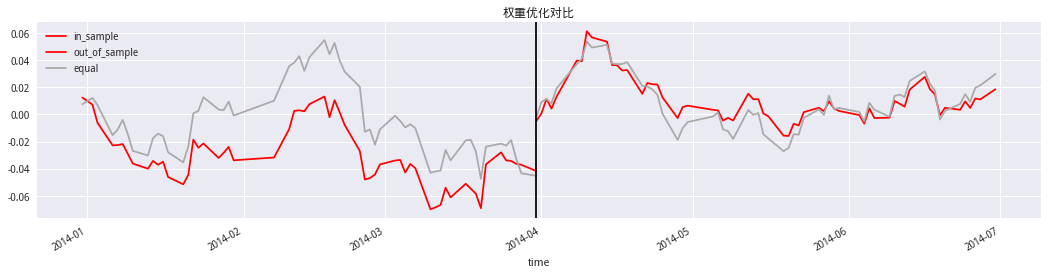

In [91]:
price = get_price(etfList,
                  start_date=tdaysoffset(timeRange[0][0],-60),
                  end_date=timeRange[0][1],
                  fields='close',
                  panel=False)

price = pd.pivot_table(price,index='time',columns='code',values='close')

pct_chg = price.pct_change().iloc[1:]
# 样本内
in_sample = pct_chg.loc[:timeRange[0][0]]
# 样本外
out_of_sample = pct_chg.loc[timeRange[0][0]:]

fig,ax = plt.subplots(figsize=(18,4))
ax.set_title('权重优化对比')

ep.cum_returns(in_sample @ best_x).plot(ax=ax,label='in_sample',color='r')
ep.cum_returns(out_of_sample @ best_x).plot(ax=ax,label='out_of_sample',color='r')
ep.cum_returns(out_of_sample.mean(axis=1)).plot(ax=ax,label='equal',color='darkgray')
ep.cum_returns(in_sample.mean(axis=1)).plot(ax=ax,label='equal',color='darkgray')
plt.axvline(timeRange[0][0],color='black')

h1,l1 = ax.get_legend_handles_labels()
h1 = h1[:-1]
l1 = l1[:-1]
plt.legend(h1,l1)

**回测逻辑:**

在每季度计算标的的最优权重(使用前125日的数据),持有至下一个季度换仓。

即在T-1日收盘后，使用T-1至T-(1-N)日收益率序列进行组合优化，在T日按照T-1日的优化结果持有对应的标的,直至下一个换仓日。

In [7]:
# 计算权重
def get_weight(opt:DEPortfolioOpt,codes:list,watch_date:str,N:int,)->pd.Series:
    
    '''获取组合权重'''
    
    price = get_price(codes,end_date=watch_date,count=N,fields='close',panel=False)
    close = pd.pivot_table(price,index='time',columns='code',values='close')
    
    # 收益滞后一期 去除头尾的na值
    pct_df = close.pct_change().iloc[1:]
    
    return opt.fit(pct_df)

In [8]:
# 计算每期的权重
'''
每季度获取前125日的数据进行组合优化
在观察日的基础上前移一天避免未来数据
'''

etf_weight_dic = {tradeDt: get_weight(DEPortfolioOpt(maxDrawdown,150,200,0.5,1), etfList, tdaysoffset(
    tradeDt, -2), 126) for tradeDt in timeRange[0]}

In [12]:
# 回测
returns_df = BackTesting(timeRange,etf_weight_dic)

每一期组合优化回撤与等权回撤对比

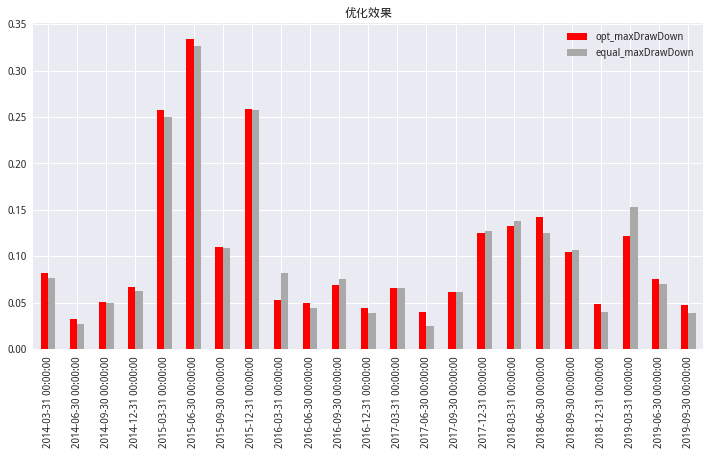

In [13]:
# 查看优化的组合回撤情况

max_drawdown_df = pd.DataFrame(index=pd.to_datetime(timeRange[0])
                               ,columns=['opt_maxDrawDown','equal_maxDrawDown'])

for s,e in zip(*timeRange):
    
    
    max_drawdown_df.loc[s,'opt_maxDrawDown'] = - ep.max_drawdown(returns_df.loc[s:e,'opt_ret'])
    max_drawdown_df.loc[s,'equal_maxDrawDown'] = - ep.max_drawdown(returns_df.loc[s:e,'equal_ret'])
    
plt.rcParams['font.family']='serif'
max_drawdown_df.plot.bar(y=['opt_maxDrawDown','equal_maxDrawDown'],
                         color=['r','darkgray'],
                         title='优化效果',
                        figsize=(12,6))

# 最大回撤（MD）最小化：

**目标函数**

1. 最大回撤(MD)最小



$$
\begin{matrix}
    min\ maxDrawdown(\sum^{}_{}w_ir_i) \\
    subject\ to\ \sum^{}_{}w_i=1 \\
                   0\leq w_i\leq 1\\
\end{matrix}
$$


## ETF标的池一

有一定的优化效果,但感觉效果并不是特别好。

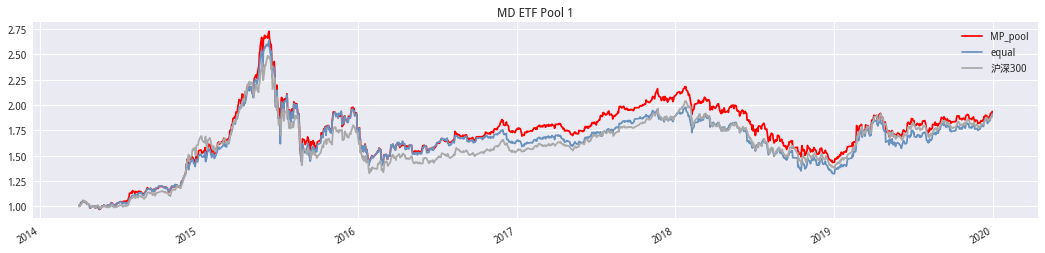

In [14]:

cumRet = 1 + ep.cum_returns(returns_df)

cumRet.plot.line(y=['opt_ret','equal_ret','benchmark'],
                 label=['MP_pool','equal','沪深300'],
                 color=['r','#6891BD','darkgray'],
                 figsize=(18,4),
                title='MD ETF Pool 1')

In [15]:
# 风险指标s
Strategy_performance(returns_df,'daily').style.format('{:.2%}')

,opt_ret,equal_ret,benchmark
年化收益率,12.57%,12.33%,12.22%
波动率,25.81%,26.57%,23.90%
夏普,58.89%,57.14%,60.30%
最大回撤,-48.25%,-49.96%,-46.70%
IR,0.14%,0.14%,nan%
Alpha,15.32%,14.94%,nan%


## ETF标的池二

In [16]:
etfList2 = ('510050.XSHG,510500.XSHG,510300.XSHG,159915.XSHE,510180.XSHG,159901.XSHE,'
            '510230.XSHG,159928.XSHE,510880.XSHG,159938.XSHE,159902.XSHE,512070.XSHG,'
            '159939.XSHE,159905.XSHE,159910.XSHE').split(',')

In [17]:
# 计算每期的权重
# 每季度获取前125日的数据进行组合优化
# 在观察日的基础上前移一天避免未来数据
etf_weight_dic2 = {tradeDt: get_weight(DEPortfolioOpt(maxDrawdown,150,200,0.5,1), etfList2, tdaysoffset(
    tradeDt, -2), 126) for tradeDt in timeRange[0]}

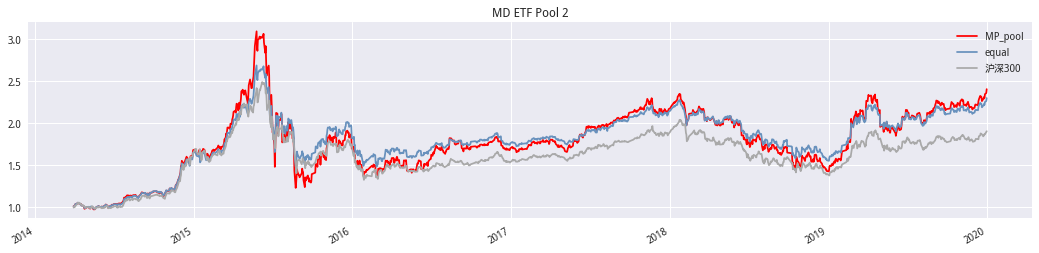

In [18]:
returns_df = BackTesting(timeRange,etf_weight_dic2)
cumRet = 1 + ep.cum_returns(returns_df)

cumRet.plot.line(y=['opt_ret','equal_ret','benchmark'],
                 label=['MP_pool','equal','沪深300'],
                 color=['r','#6891BD','darkgray'],
                 figsize=(18,4),
                title='MD ETF Pool 2')

In [19]:
# 风险指标
Strategy_performance(returns_df,'daily').style.format('{:.2%}')

,opt_ret,equal_ret,benchmark
年化收益率,17.01%,16.06%,12.22%
波动率,34.83%,25.42%,23.90%
夏普,62.69%,71.41%,60.30%
最大回撤,-60.17%,-44.79%,-46.70%
IR,1.14%,0.69%,nan%
Alpha,20.49%,17.33%,nan%


# 预期损失（CVaR）最小化

**目标函数**

2. 预期损失(CVaR)最小化

<font size=4.5>$$min\ \frac{w_{i}\big[-\mu_{i}+\frac{(\sum{w})_{i}\phi(Z_{\alpha})}{\sqrt{w'\Sigma w}\alpha}\big]}{-w'\mu+\sqrt{w'\Sigma w}\frac{\phi(Z_{\alpha})}{\alpha}}$$</font>

$$subject \sum{w_{i}}=1$$

$$0\leq w_{i} \leq 1 $$

In [20]:
# CVaR
def calcCVaR(returns:pd.DataFrame,w:np.array,alpha:float=0.05)->float:
    '''目标函数'''
    #w = np.ones(pct_chg.shape[1]) / pct_chg.shape[1] # 组合权重-等权
    N = len(returns)
    p_mean = (returns @ w).mean() # 组合收益平均值 
    p_var = (returns @ w).var()   # 组合方差
    p_std = np.sqrt(p_var)        # 组合标准差

    p_std_h = p_std * np.sqrt(N / 252)

    CVaR = alpha ** (-1) * st.norm.pdf(st.norm.ppf(alpha)) * p_std_h - p_mean
    
    return CVaR

## ETF标的池一

回测结果与研报相当

In [21]:
# 计算每期的权重
# 每季度获取前125日的数据进行组合优化
# 在观察日的基础上前移一天避免未来数据
etf_weight_dic3 = {tradeDt: get_weight(DEPortfolioOpt(calcCVaR,150,200,0.5,1), etfList, tdaysoffset(
    tradeDt, -2), 126) for tradeDt in timeRange[0]}

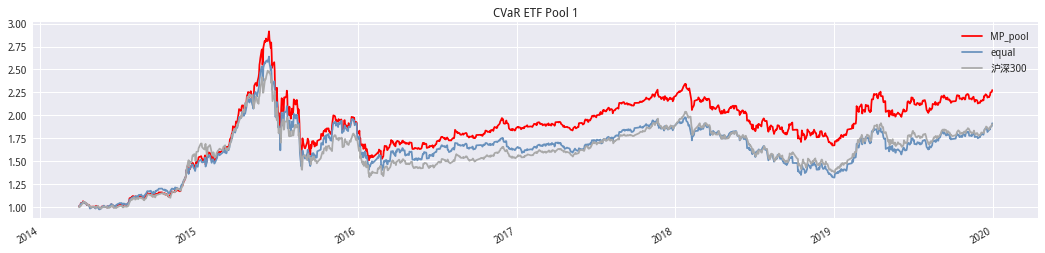

In [22]:
returns_df = BackTesting(timeRange,etf_weight_dic3)
cumRet = 1 + ep.cum_returns(returns_df)

cumRet.plot.line(y=['opt_ret','equal_ret','benchmark'],
                 label=['MP_pool','equal','沪深300'],
                 color=['r','#6891BD','darkgray'],
                 figsize=(18,4),
                title='CVaR ETF Pool 1')

In [23]:
# 风险指标
Strategy_performance(returns_df,'daily').style.format('{:.2%}')

,opt_ret,equal_ret,benchmark
年化收益率,15.87%,12.33%,12.22%
波动率,25.00%,26.57%,23.90%
夏普,71.49%,57.14%,60.30%
最大回撤,-48.20%,-49.96%,-46.70%
IR,0.64%,0.14%,nan%
Alpha,17.58%,14.94%,nan%


## ETF标的池二

In [24]:
# 计算每期的权重
# 每季度获取前125日的数据进行组合优化
# 在观察日的基础上前移一天避免未来数据
etf_weight_dic4 = {tradeDt: get_weight(DEPortfolioOpt(calcCVaR,150,200,0.5,1), etfList2, tdaysoffset(
    tradeDt, -2), 126) for tradeDt in timeRange[0]}

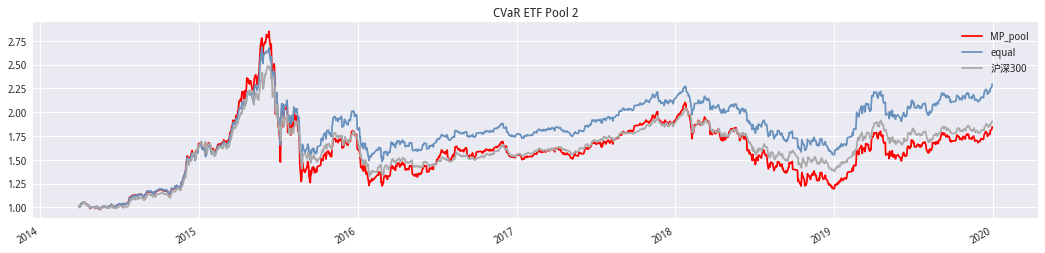

In [25]:
returns_df = BackTesting(timeRange,etf_weight_dic4)
cumRet = 1 + ep.cum_returns(returns_df)

cumRet.plot.line(y=['opt_ret','equal_ret','benchmark'],
                 label=['MP_pool','equal','沪深300'],
                 color=['r','#6891BD','darkgray'],
                 figsize=(18,4),
                title='CVaR ETF Pool 2')

In [26]:
# 风险指标
Strategy_performance(returns_df,'daily').style.format('{:.2%}')

,opt_ret,equal_ret,benchmark
年化收益率,11.60%,16.06%,12.22%
波动率,33.01%,25.42%,23.90%
夏普,49.92%,71.41%,60.30%
最大回撤,-58.03%,-44.79%,-46.70%
IR,0.33%,0.69%,nan%
Alpha,15.41%,17.33%,nan%


在ETF基金池二中的效果不太理想,查看F=0.5,prob_mut=1,max_iter=200时的拟合情况，由下图可以看到200左右数值都还有较大的变动,在250至300次时,数据任然在等权的回撤之上。可能需要重新调整参数才能达到较好的优化效果。

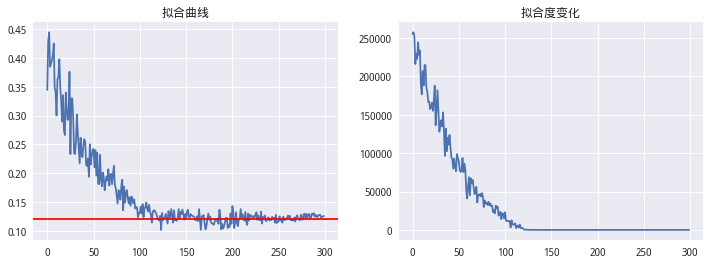

In [33]:
price = get_price(etfList2,end_date = timeRange[0][0],count=126,fields='close',panel=False)

price = pd.pivot_table(price,index='time',columns='code',values='close')

pct_chg = price.pct_change().iloc[1:]

cvar = DEPortfolioOpt(calcCVaR,150,300,0.5,1)
cvar.fit(pct_chg)

equal = -ep.max_drawdown(pct_chg.mean(axis=1))

# 回撤情况    
maxdrawdownList = [-ep.max_drawdown(pct_chg @ w) for w in cvar.de.generation_best_X]

plt.rcParams['font.family']='serif'
fig,axes = plt.subplots(1,2,figsize=(6 * 2,4))

axes[0].set_title('拟合曲线')
axes[0].plot(maxdrawdownList,label='拟合的回撤')
axes[0].axhline(equal,color='r',label='等权回撤')

axes[1].set_title('拟合度变化')
axes[1].plot(cvar.de.generation_best_Y)